In [1]:
#!/usr/bin/env python
"""
Demo for tomography test problem on a small scale problem
--------------------------------------------------------------------------
Created in 2023 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha, Silvia Gazzola, Connor Sanderford, and Ugochukwu Obinna Ugwu"
__affiliations__ = 'Tufts University, University of Bath, Arizona State University, and Tufts University'
__copyright__ = "Copyright 2023, TRIPs-Py library"
__license__ = "GPL"
__version__ = "1.0"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com; sg968@bath.ac.uk; csanderf@asu.edu; connorsanderford@gmail.com; Ugochukwu.Ugwu@tufts.edu"

In [4]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum
from numpy.linalg import inv
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import numpy as np
import astra
from trips.utilities.phantoms import *
from venv import create
import pylops
from scipy.ndimage import convolve
from scipy import sparse
import scipy.special as spe
from trips.test_problems.Tomography import *
from trips.solvers.GKS import *
from trips.solvers.MMGKS import *
from trips.solvers.Tikhonov import *
from trips.solvers.tSVD import *
from trips.utilities.helpers import *
from trips.solvers.CGLS import CGLS
# from trips.solvers.golub_kahan_tikhonov import *
from trips.solvers.GMRES import GMRES

#### In this notebook we illustrate how to use the Tomography class. The main features are:
1. Define e tomography problem. Show how the forward operator can be accessed as a matrix (for relatively small problems).
 - 1.1 We show how to use SVD, compute the singular values of the operator, and illustrate the truncated SVD solution
 - 1.2 We use regularization methods for computing an approximate solution


In [10]:

class Tomography1C():
    def __init__(self,**kwargs):
        seed = kwargs.pop('seed',2022)
        self.nx = None
        self.ny = None
        self.CommitCrime = kwargs['CommitCrime'] if ('CommitCrime' in kwargs) else False
        print('settings')
    
    def define_proj_id(self, nx, ny, views, **kwargs):
        self.dataset = kwargs['dataset'] if ('dataset' in kwargs) else False
        self.nx = nx
        self.ny = ny
        self.p = int(np.sqrt(2)*self.nx)    # number of detector pixels
        self.q = views           # number of projection angles
        self.views = views
        self.theta = np.linspace(0, np.pi, self.q, endpoint=False)   # in rad
        self.source_origin = 3*self.nx                     # source origin distance [cm]
        self.detector_origin = self.nx                      # origin detector distance [cm]
        self.detector_pixel_size = (self.source_origin + self.detector_origin)/self.source_origin
        self.detector_length = self.detector_pixel_size*self.p   # detector length
        self.vol_geom = astra.create_vol_geom(self.nx,self.nx)
        if self. CommitCrime == False:
            self.theta_mis = self.theta + 1e-8
            self.proj_geom_mis = astra.create_proj_geom('fanflat', self.detector_pixel_size, self.p, self.theta_mis, self.source_origin, self.detector_origin)
            self.proj_id_mis = astra.create_projector('line_fanflat', self.proj_geom_mis, self.vol_geom)
        self.proj_geom = astra.create_proj_geom('fanflat', self.detector_pixel_size, self.p, self.theta, self.source_origin, self.detector_origin)
        self.proj_id = astra.create_projector('line_fanflat', self.proj_geom, self.vol_geom)
        # return self.proj_id

    def define_A(self, nx, ny, views): 
            # proj_id = self.define_proj_id(nx, ny, views)
            self.define_proj_id(nx, ny, views)  
            self.A = astra.OpTomo(self.proj_id)
            if self. CommitCrime == False:
                self.A_mis = astra.OpTomo(self.proj_id_mis)
            # return self.A

    def forward_Op(self, x, nx, ny, views):
        A = self.define_A(nx, ny, views)
        self.define_A(nx, ny, views)
        operatorf = lambda X: (self.A*X.reshape((nx, ny))).reshape(-1,1)
        operatorb = lambda B: self.A.T*B.reshape((self.p, self.q))
        OP = pylops.FunctionOperator(operatorf, operatorb, self.p*self.q, nx*ny)
        if self. CommitCrime == False:
            A_mis = self.A_mis
            return OP, A, A_mis
        else:
            return OP, A

    def gen_true(self, test_problem, **kwargs):
        print('MP')
        if (self.nx is None or self.ny is None):
            if (('nx' in kwargs) and ('ny' in kwargs)):
                self.nx = kwargs['nx'] 
                self.ny = kwargs['ny'] 
            else:
                raise TypeError("The dimension of the image is not specified. You can input nx and ny as (x_true, nx, ny) = Tomo.gen_true(testproblem, nx = nx, ny = ny) or first define the forward operator")
        
        if test_problem in ['SL60', 'SL90', 'head']:
            image = self.im_image_dat(test_problem)
            newimage = image
            current_shape = get_input_image_size(image)
            if ((current_shape[0] is not self.nx) and (current_shape[1] is not self.ny)):
                newimage = image_to_new_size(image, (self.nx, self.ny))
                newimage[np.isnan(newimage)] = 0
                x_truef = newimage
                self.nx = newimage.shape[0]
                self.ny = newimage.shape[1]
            else:
                self.nx = current_shape[0]
                self.ny = current_shape[1]
        elif test_problem in ['grains', 'smooth', 'tectonic', 'threephases', 'ppower']:
            if test_problem == 'grains':
                N_fine = self.nx
                numGrains = int(round(4*np.sqrt(N_fine)))
                x_true = phantom.grains(N_fine, numGrains) 
                tmp_shape = x_true.shape
                self.nx = tmp_shape[0]
                self.ny = tmp_shape[1]
                x_truef = x_true.reshape((-1,1)) 
            elif test_problem == 'smooth':
                N_fine = self.nx
                x_true = phantom.smooth(N_fine) 
                tmp_shape = x_true.shape
                self.nx = tmp_shape[0]
                self.ny = tmp_shape[1]
                x_truef = x_true.reshape((-1,1)) 
            elif test_problem == 'tectonic':
                N_fine = self.nx
                x_true = phantom.tectonic(N_fine)
                tmp_shape = x_true.shape
                self.nx = tmp_shape[0]
                self.ny = tmp_shape[1] 
                x_truef = x_true.reshape((-1,1)) 
            elif test_problem == 'threephases':
                N_fine = self.nx
                x_true = phantom.threephases(N_fine) 
                tmp_shape = x_true.shape
                self.nx = tmp_shape[0]
                self.ny = tmp_shape[1]
                x_truef = x_true.reshape((-1,1)) 
            elif test_problem == 'ppower':
                N_fine = self.nx
                x_true = phantom.ppower(N_fine) 
                tmp_shape = x_true.shape
                self.nx = tmp_shape[0]
                self.ny = tmp_shape[1]
                x_truef = x_true.reshape((-1,1)) 
        else:
            raise TypeError("You must enter a valid test problem! Options are: grains, smooth, tectonic, threephases, ppower, CT60, CT90, head.")
        
        return (x_truef, self.nx, self.ny)

    def gen_data(self, x, nx, ny, views):
        self.nx = nx
        self.ny = ny
        self.views = views
        if self. CommitCrime == False:
            (A, AforMatrixOperation, A_mis) = self.forward_Op(x, self.nx, self.ny, self.views)
            b = (A_mis*x.reshape((nx,ny))).reshape((-1,1))
            print('no crime')
        else:
            (A, AforMatrixOperation) = self.forward_Op(x, self.nx, self.ny, self.views)
            b = A@x.reshape((-1,1))
            print('crime')
        bshape = b.shape
        self.p = self.views
        self.q = int(bshape[0]/self.views)
        return A, b, self.p, self.q, AforMatrixOperation
    
    def gen_saved_data(self, dataset):
        if dataset == 60:
           test_problem = 'SL60'
           otherdata = 'CT60'
           data = self.im_other_dat(test_problem)
           CT = self.im_other_dat(otherdata)
           A, phi, s = CT['A'],CT['phi'],CT['s']
           x_true = data['x_true']
           b = data['b'].T#A*x_true.reshape((-1,1))
           self.q = phi.shape[1]
           self.p = s.shape[1]
        elif dataset == 90:
           test_problem = 'SL90'
           otherdata = 'CT90'
           data = self.im_other_dat(test_problem)
           CT = self.im_other_dat(otherdata)
           A, phi, s = CT['A'],CT['phi'],CT['s']
           x_true = data['x_true']
           b = data['x_true']['b'].T#A*x_true.reshape((-1,1))
           b = b[0][0]
           self.q = phi.shape[1]
           self.p = s.shape[1]
        elif dataset == 'head':
            test_problem = 'head'
            otherdata = 'CT200'
            data = self.im_other_dat(test_problem)
            CT = self.im_other_dat(otherdata)
            A,phi,s = CT['A'],CT['phi'],CT['s']
            x_true, b = data['x_true'], data['b']
            b = b.T
            b = b
        return (A, x_true, b)
    
    def add_noise(self, b_true, opt, noise_level):
        if (opt == 'Gaussian'):
            # mu_obs = np.zeros((self.p*self.q,1))      # mean of noise
            noise = np.random.randn(b_true.shape[0]).reshape((-1,1))
            e = noise_level * np.linalg.norm(b_true) / np.linalg.norm(noise) * noise
            e = e.reshape((-1,1))
            b_true = b_true.reshape((-1,1))
            delta = la.norm(e)
            b = b_true + e # add noise
            b_meas = b_true + e
            b_meas_i = b_meas.reshape((self.p, self.q))
        elif (opt == 'Poisson'):
            # Add Poisson Noise 
            gamma = 1 # background counts assumed known
            b_meas = np.random.poisson(lam=b_true+gamma) 
            b_meas_i = b_meas.reshape((self.p, self.q))
            delta = 0
        else:
            mu_obs = np.zeros(self.p*self.q)      # mean of noise
            e = np.random.laplace(self.p*self.q)
            sig_obs = noise_level * np.linalg.norm(b_true)/np.linalg.norm(e)
            b_meas = b_true + sig_obs*e
            delta = la.norm(sig_obs*e)
            b_meas_i = b_meas.reshape((self.p, self.q))
        return (b_meas_i , delta)

    def plot_rec(self, img, save_imgs=True, save_path='./saveImagesTomo'):
            plt.set_cmap('inferno')
            if save_imgs and not os.path.exists(save_path): os.makedirs(save_path)
            plt.imshow(img.reshape((self.nx, self.ny)))
            plt.axis('off')
            if save_imgs:  plt.savefig(save_path+'/rec'+'.png',bbox_inches='tight')
            plt.pause(.1)
            plt.draw()

    def im_other_dat(self, im):
        if exists(f'./data/image_data/{im}.mat'):
            print('data already in the path.')
        else:
            print("Please make sure your data are on the data folder!")
        f = spio.loadmat(f'./data/image_data/{im}.mat')
        return f
    
    def im_image_dat(self, im):
        if exists(f'./data/image_data/{im}.mat'):
            print('data already in the path.')
        else:
            print("Please make sure your data are on the data folder!")
        f = spio.loadmat(f'./data/image_data/{im}.mat')
        X = f['x_true']
        im_shape = X.shape
        if len(im_shape) == 3:
             X = 0.4*X[:, :, 0] + 0.4*X[:, :, 1] + 0.1*X[:, :, 2]
        return X  
    
    def plot_data(self, img, save_imgs = False, save_path='./saveImagesData'):
        plt.set_cmap('inferno')
        if save_imgs and not os.path.exists(save_path): os.makedirs(save_path)
        plt.imshow(img.reshape((self.p, self.q)))
        plt.axis('off')
        if save_imgs:  plt.savefig(save_path+'/sino'+'.png',bbox_inches='tight')
        plt.pause(.1)
        plt.draw()


In [11]:
# Define an object of the class Tomogrpahy
Tomo = Tomography1C()
# Specify the dimensions of the phantom and the number of angels that we call views
views = 30
nx = 32
ny = 32
# Step 1: Define the true solution throught the function gen_true(). 
# Options are: grains, smooth, tectonic, threephases, ppower
testproblem = 'tectonic'
(x_true, nx, ny) = Tomo.gen_true(testproblem, nx, ny)
# Step 2: Define the forward operator
A = Tomo.forward_Op(x_true, nx, ny, views)
# Generate the data: We can skip Step 1 and generate the sinogram and the operator by the following lines
(A, b_true, p, q, AforMatrixOperation) = Tomo.gen_data(x_true, nx, ny, views)
# Add noise in the true simulated sinogram b_true
# The opt defines the type of the noise. Options are Gaussian, Laplace, and Poisson
# The noise level defines the percentage of the noise added in the data. A value 0.01 means 1% additive noise
(b, delta) = Tomo.add_noise(b_true = b_true, opt = 'Gaussian', noise_level = 0.01)
b_vec = b.reshape((-1,1))

settings


TypeError: gen_true() takes 2 positional arguments but 4 were given

##### 1.1. Compute the SVD of the operartor $A$ and plot the singlar values and the singular vectors
###### If the parameter is 'A' then we give the full operator to the function plot_singular_values_svd. The SVD is then computed and the singlar values are plotted. If the parameter is 'S' then we have precomputed the SVD from which we have S and the function plot_singular_values_svd will only plot the singular values. The same applies for plotting the singular vectors. If the operaror is not given, we give the matrix V.

In [7]:
# First we compute a naive solution
# x_naive = A.T@b.reshape((-1,1))
AA = A.todense()
x_naive = np.linalg.solve(AA.T@AA, AA.T@b_vec)

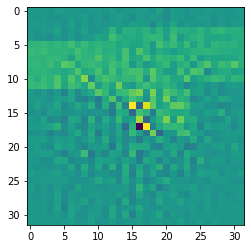

In [8]:
plt.imshow(x_naive.reshape((nx, ny)))

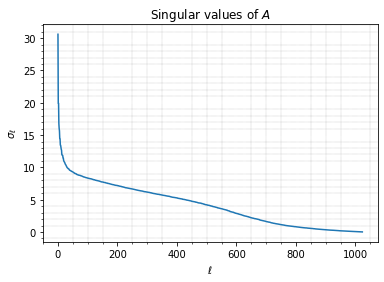

In [9]:
# If the operator is sparse, we convert it to dense A.todense()
plot_singular_values_svd(Operator = A , parameter = 'A')
# If the operator is in the matrix form, but very large and sparse, the following commands can be used to compute the SVD
# import scipy
# [U, S, V] = scipy.sparse.linalg.svds(A, 100)
# 100 defines the number of singular values to be computed

##### Plot some of the singular vectors

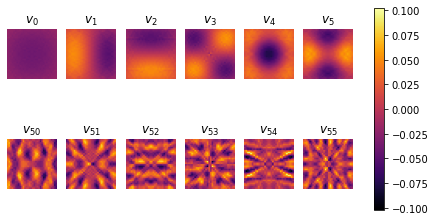

In [10]:
plot_singular_vectors_svd(Operator = A, size = nx, parameter = 'A')

##### 1.2. Compute the truncated SVD solution of a problem by specifying how many singular values you want to keep after truncation

(-0.5, 31.5, 31.5, -0.5)

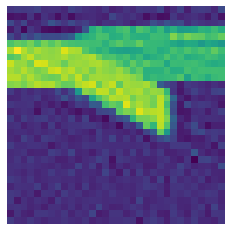

In [16]:
truncated_value = 600 # a value that can be changed to define a good regularization parameter
b_vec = b.reshape((-1,1))
(x_tsvd, truncation_value) = TruncatedSVD_sol(A.todense(), b_vec, regparam = 'dp', delta = delta)
plt.imshow(x_tsvd.reshape((nx, ny)))
plt.axis('off')